In [1]:
import sys
quic_path = '/home/quic/QUIC-Projects'
if not quic_path in sys.path:
    sys.path.append(quic_path)

In [2]:
import numpy as np 
from matplotlib import pyplot as plt

# This notebook is to find optimal dataset that maximize classifing equation value

In [21]:
from classifiers.convex.svm import BinarySVM
from classifiers.kernel import Kernel
kernel = Kernel('SingleQubit')
svm = BinarySVM(kernel, C=None, k=10, mutation='REDUCED_QASVM')
uniform_svm = BinarySVM(kernel, C=None, k=10, mutation='REDUCED_uniform_QASVM')

In [35]:
myf = lambda x: np.exp(-x)
myg = lambda x: np.exp(x)*x**2
from scipy.optimize import minimize
def cost_fn(params, n=2):
    X = params.reshape(2*n, 2)
    y = np.concatenate((np.zeros(n), np.ones(n)))
    # y = np.ones(2*n)
    # y[0]=0
    svm.fit(X, y)
    uniform_svm.fit(X, y)
    vector = svm.f(X)
    uniform_vector = uniform_svm.f(X)
    #return max(vector[0:n])-min(vector[n:2*n]) - sum(np.abs(svm.alpha)**2) - ( max(uniform_vector[0:n])-min(uniform_vector[n:2*n]))
    return np.sum(myf(y*vector)) + 1.1**5*np.sum(myg(y*uniform_vector))
    #return max([vector[0]])-min(vector[1:]) - sum(np.abs(svm.alpha)**2)
np.random.seed()
result = minimize(cost_fn, args=(2,), x0=np.random.randn(8), method='SLSQP', bounds=tuple(zip(-np.pi*np.ones(8), np.pi*np.ones(8))))

In [36]:
np.random.seed()
X = result.x.reshape(4, 2)
y = np.array([0, 0, 1, 1])

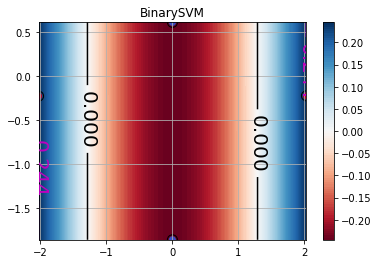

In [37]:
svm.fit(X, y)
from classifiers.visualization import Plot_SVM
Plot_SVM(svm).plot_boundary()

0.24425168869953984


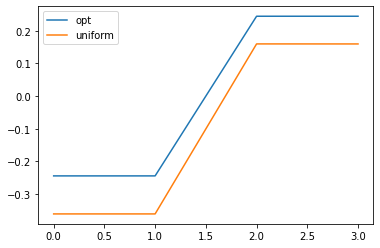

In [38]:
svm.fit(X, y)
uniform_svm.fit(X, y)
plt.plot(svm.f(X), label='opt')
plt.plot(uniform_svm.f(X), label='uniform')
plt.legend()
print(max(svm.f(X)))

In [26]:
X

array([[ 3.13130030e+00,  1.19915797e+00],
       [-2.42646069e-03, -1.80487192e+00],
       [ 1.42963078e-03,  2.86109728e-01],
       [ 3.17828004e-04,  9.71989753e-01]])

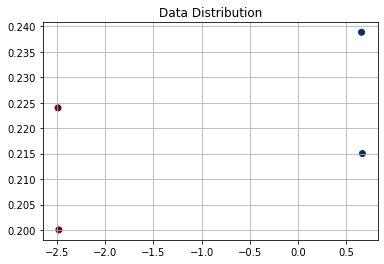

In [9]:
from classifiers.visualization import Plot_Data
Plot_Data(X, y).plot()

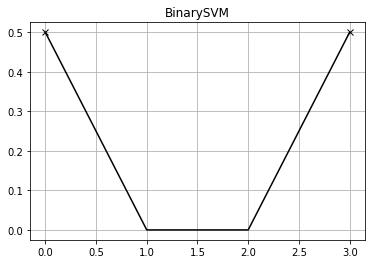

In [10]:
Plot_SVM(svm).plot('alpha')

In [11]:
result

     fun: -1.4998074421179448
     jac: array([ 0.05230537, -0.03436762, -0.05079196,  0.02920637, -0.04906406,
        0.02853717,  0.04785356, -0.02337554])
 message: 'Optimization terminated successfully'
    nfev: 228
     nit: 22
    njev: 22
  status: 0
 success: True
       x: array([-2.47863439,  0.20001953, -2.4874644 ,  0.22398983,  0.66760897,
        0.2150178 ,  0.65884413,  0.23884562])

# QASVM

In [12]:
# for SVM
from classifiers.convex.svm import BinarySVM
from classifiers.kernel import Kernel
from classifiers.datasets.dataloader import Example_4x2
# for QASVM
from classifiers.quantum import Qasvm_Mapping_4x2
from classifiers.quantum.qasvm import QASVM
from classifiers.optimizer import SPSA
from qiskit.utils import QuantumInstance
from qiskit.ignis.mitigation import CompleteMeasFitter
from qiskit.circuit.library import RealAmplitudes, EfficientSU2, NLocal, TwoLocal
from qiskit.providers.aer import AerSimulator
from qiskit import IBMQ
# for logging & visualization
import logging
from classifiers.callback import CostParamStorage, ParamsStopping
from torch.utils.tensorboard import SummaryWriter
from classifiers.visualization import Plot_Data, Plot_Log_From_SPSA, Plot_SVM, compare_svm_and_qasvm

if IBMQ.active_account() is None:
    IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-kaist', group='internal', project='default')
backend = provider.get_backend('ibmq_toronto')
backend

<IBMQBackend('ibmq_toronto') from IBMQ(hub='ibm-q-kaist', group='internal', project='default')>

In [13]:
import qiskit.tools.jupyter
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [14]:
from scipy.optimize import minimize
from tqdm.notebook import tqdm
def cost_fn_qasvm(params, balanced, C=None, k=10):
    X = params.reshape(4, 2)
    if balanced:
        y = np.concatenate((np.zeros(2), np.ones(2)))
    else:
        y = np.ones(2*n)
        y[0]=0
    var_form = RealAmplitudes(2, reps=1)
    quantum_instance = QuantumInstance(backend=backend, shots=2**13, initial_layout=Qasvm_Mapping_4x2(backend), measurement_error_mitigation_cls=CompleteMeasFitter, optimization_level=2, seed_transpiler=0)
    qasvm = QASVM(X, y, quantum_instance=quantum_instance, C=C, k=k, option='Bloch_uniform', var_form=var_form).dual
    vector=qasvm.f(X)
    if balanced:
        return max(vector[0:2])-min(vector[2:4])
    else:
        return max([vector[0]])-min(vector[1:])
np.random.seed(None)
result = minimize(cost_fn_qasvm, args=(True, None, 10), x0=result.x, method='SLSQP', bounds=tuple(zip(-np.pi*np.ones(8), np.pi*np.ones(8))))

<class 'classifiers.quantum.quantum_circuits.Bloch_uniform_QASVM_circuit'> ignores var_form. Set 'circuit_class' first to modify 'var_form'
/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:382: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj, **backend_options, **noise_config)
<class 'classifiers.quantum.quantum_circuits.Bloch_uniform_QASVM_circuit'> ignores var_form. Set 'circuit_class' first to modify 'var_form'
/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:382: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj, **backend_options, **noise_config)
<class 'classifiers.quantum.quantum_circuits.Bloch_uniform_QASVM_circuit'> ignores var_form. Set '

<class 'classifiers.quantum.quantum_circuits.Bloch_uniform_QASVM_circuit'> ignores var_form. Set 'circuit_class' first to modify 'var_form'
/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:382: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj, **backend_options, **noise_config)
<class 'classifiers.quantum.quantum_circuits.Bloch_uniform_QASVM_circuit'> ignores var_form. Set 'circuit_class' first to modify 'var_form'
/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:382: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj, **backend_options, **noise_config)
<class 'classifiers.quantum.quantum_circuits.Bloch_uniform_QASVM_circuit'> ignores var_form. Set '

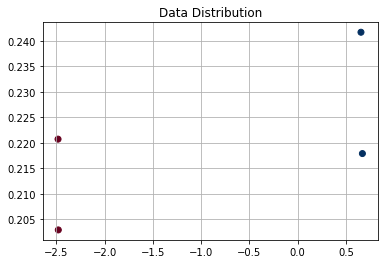

In [15]:
X = result.x.reshape(4, 2)
y = np.array([0, 0, 1, 1])
Plot_Data(X, y).plot()

In [22]:
var_form = RealAmplitudes(2, reps=1)
quantum_instance = QuantumInstance(backend=backend, shots=2**13, initial_layout=Qasvm_Mapping_4x2(backend), measurement_error_mitigation_cls=CompleteMeasFitter, optimization_level=2, seed_transpiler=0)
qasvm = QASVM(X, y, quantum_instance=quantum_instance, C=None, k=10, option='Bloch_uniform', var_form=var_form).dual


<class 'classifiers.quantum.quantum_circuits.Bloch_uniform_QASVM_circuit'> ignores var_form. Set 'circuit_class' first to modify 'var_form'


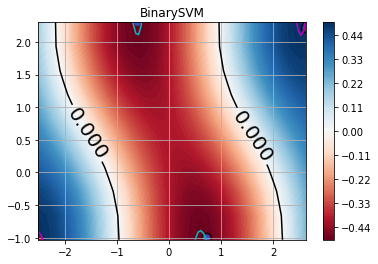

In [23]:
svm.fit(X, y)
from classifiers.visualization import Plot_SVM
Plot_SVM(svm).plot_boundary()

/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:382: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj, **backend_options, **noise_config)
/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:382: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj, **backend_options, **noise_config)
/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:382: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj, **backend_options, **noise_config)
/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/u

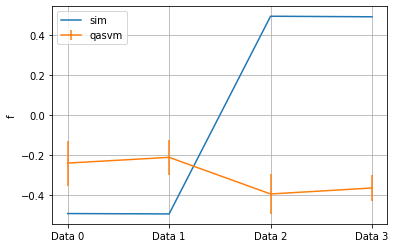

In [24]:
svm.fit(X, y)
compare_svm_and_qasvm(svm, qasvm)

/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:382: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj, **backend_options, **noise_config)
/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:382: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj, **backend_options, **noise_config)
/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:382: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj, **backend_options, **noise_config)
/home/quic/anaconda3/envs/QUIC/lib/python3.9/site-packages/qiskit/u

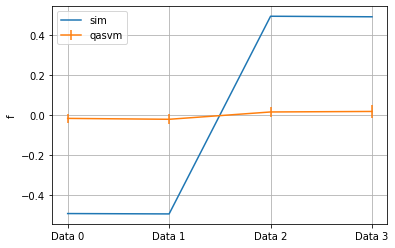

In [25]:
X, y= Example_4x2(True)()
qasvm2 = QASVM(X, y, quantum_instance=quantum_instance, C=None, k=10, option='_uc', var_form=var_form).dual
qasvm2.parameters = np.array([0, 0, np.pi/2, np.pi/2])
svm.fit(X, y)
compare_svm_and_qasvm(svm, qasvm2)